In [119]:
import pandas as pd
import numpy as np 
import os
import plotly.express as px
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import random

# For investigating timeseries data
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm

### Loading Data

In [120]:
# Reading Data
base_path =  os.getcwd()
file_name = 'Traffic_Data.xlsx'
total_path = base_path + '//Data//' 
df = pd.read_excel(total_path + file_name, sheet_name='Sheet1')

# Filtering for just one state
df = df[df['State'] == 'Oregon']
df = df.sort_values(by = ['Date'])
df.head(10)

,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
3056,Oregon,West,153,2823,2769,January,1,2019,2019-01-01
3005,Oregon,West,143,2393,2566,February,2,2019,2019-02-01
2954,Oregon,West,153,3088,3104,March,3,2019,2019-03-01
2903,Oregon,West,152,3034,2990,April,4,2019,2019-04-01
2852,Oregon,West,147,3303,3295,May,5,2019,2019-05-01
2801,Oregon,West,154,3334,3318,June,6,2019,2019-06-01
2750,Oregon,West,153,3547,3527,July,7,2019,2019-07-01
2699,Oregon,West,152,3587,3541,August,8,2019,2019-08-01
2648,Oregon,West,155,3246,3216,September,9,2019,2019-09-01
2597,Oregon,West,157,3241,3185,October,10,2019,2019-10-01


### Plotting Data

In [121]:
fig = px.scatter(df, x="Date", y="CMILES", title = 'Miles Driven by Time')
fig.show()

### Seasonal Decomposition

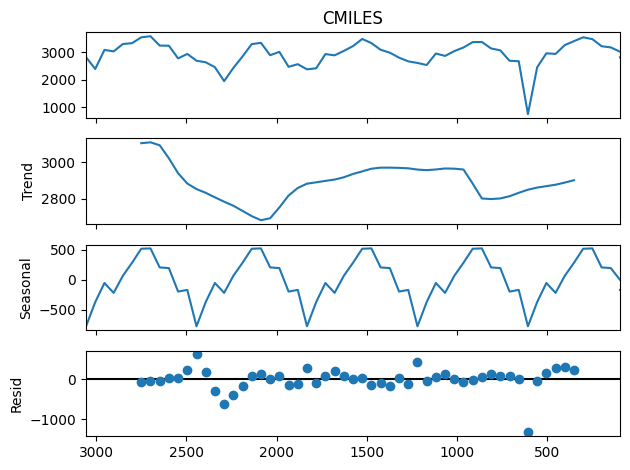

In [122]:
result = seasonal_decompose(df['CMILES'], model='additive', period=12)
result.plot()
pyplot.show()

### Splitting Into Test/Train

In [123]:
test_train_split = 0.8
pre_split = df[['CMILES', 'Date']].copy()
pre_split = pre_split.rename(columns= {'CMILES':'y',
                                       'Date':'ds'})
train = pre_split[:int(test_train_split * len(pre_split['y']))]
test = pre_split[int(test_train_split * len(pre_split['y'])):]
print('Total Length: ', len(pre_split))
print('Train Length: ', len(train))
print('Test Length: ', len(test))
test.head(10)


Total Length:  60
Train Length:  48
Test Length:  12


,y,ds
608,746,2023-01-01
557,2452,2023-02-01
506,2964,2023-03-01
455,2942,2023-04-01
404,3263,2023-05-01
353,3407,2023-06-01
302,3549,2023-07-01
251,3481,2023-08-01
200,3222,2023-09-01
149,3180,2023-10-01


### Fitting Prophet Model

In [124]:
model = Prophet()
model.fit(train)

15:43:27 - cmdstanpy - INFO - Chain [1] start processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



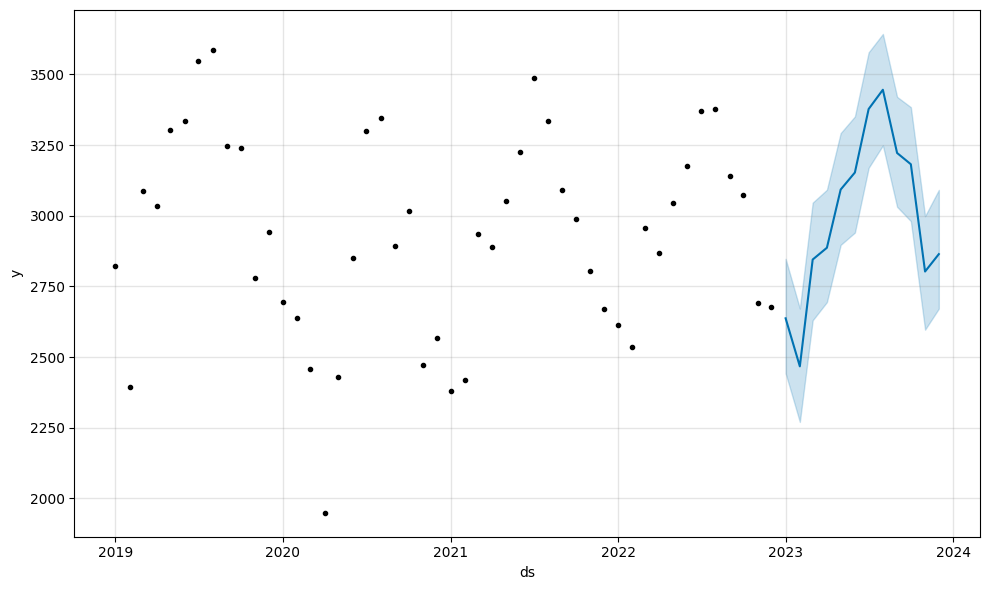

In [125]:
forecast = model.predict(test)
fig1 = model.plot(forecast)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series c

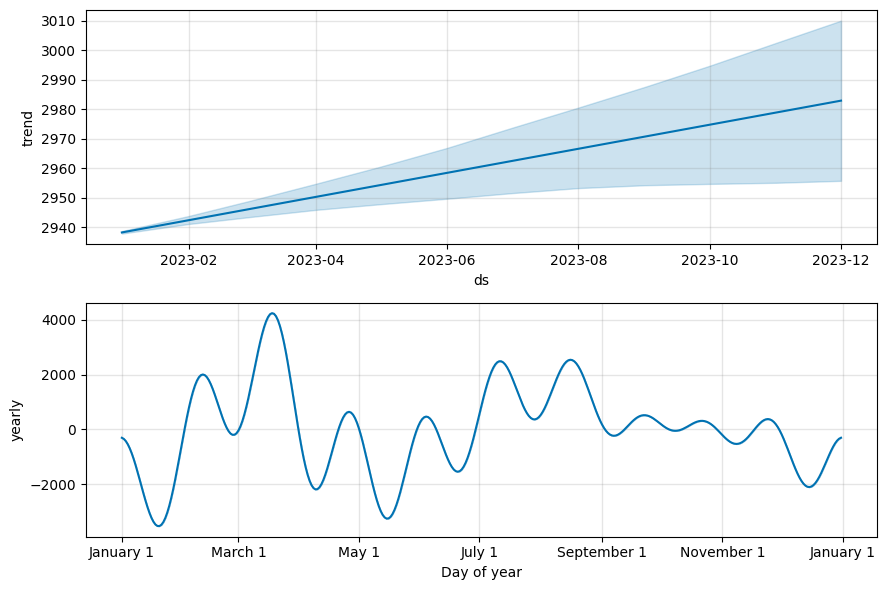

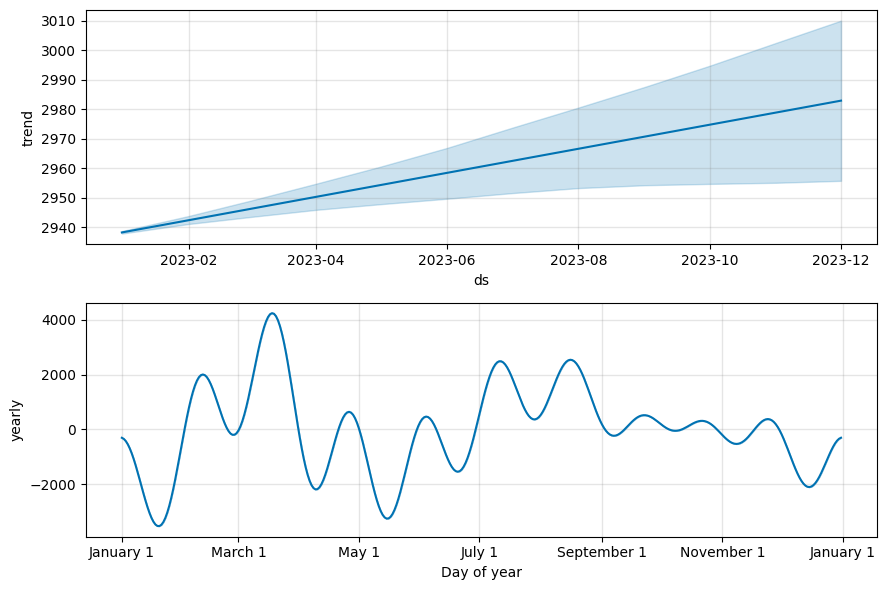

In [126]:
# Generation seasonal decomposition
model.plot_components(forecast)

In [127]:
# Want to Assess module performance
y_true = test['y'].values
y_pred = forecast['yhat'].values
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: ', mape)

MAE:  0.23534113374388013


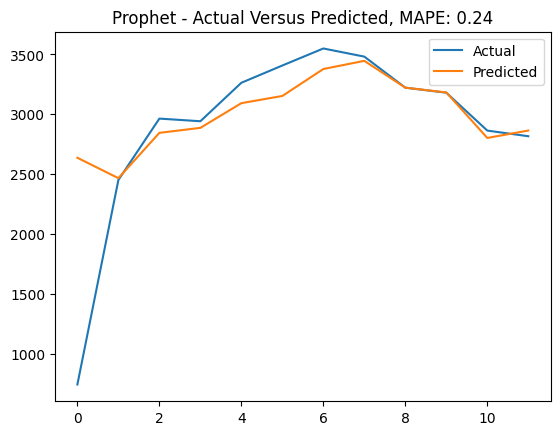

In [128]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.title("Prophet - Actual Versus Predicted, MAPE: "+ str(round(mape,2)))
pyplot.legend()
pyplot.show()

### Hyperparameter Tuning of Prophet Model

In [129]:
# Defining Parameter grid to perform hyperparameter tuning over
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.3,0.5],
              'n_changepoints' : [100,200]}
grid = ParameterGrid(params_grid)

In [130]:
random.seed(42)
model_parameters = {}
for parameters in grid:
    train_model = Prophet(changepoint_prior_scale = parameters['changepoint_prior_scale'],
                         n_changepoints = parameters['n_changepoints'],
                         seasonality_mode = parameters['seasonality_mode'],
                         yearly_seasonality = True, 
                         interval_width=0.8)
    train_model.fit(train)
    
    forecast = train_model.predict(test)
    y_true = test['y'].values
    y_pred = forecast['yhat'].values
    mape = mean_absolute_percentage_error(y_true, y_pred)
    # Adding mape + parameters to dataframe to compare models performance
    print('MAPE: ', mape, ' Parameters: ', parameters)
    model_parameters[str(parameters)] = mape


15:43:29 - cmdstanpy - INFO - Chain [1] start processing
15:43:29 - cmdstanpy - INFO - Chain [1] done processing
15:43:29 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.23449793793054963  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:43:30 - cmdstanpy - INFO - Chain [1] done processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.23665623730228524  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:43:30 - cmdstanpy - INFO - Chain [1] done processing
15:43:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.23449793793054963  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:43:31 - cmdstanpy - INFO - Chain [1] done processing
15:43:31 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.23665623730228524  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:43:32 - cmdstanpy - INFO - Chain [1] done processing
15:43:32 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.25499870217449017  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:43:33 - cmdstanpy - INFO - Chain [1] done processing
15:43:33 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.25096334862735886  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:43:34 - cmdstanpy - INFO - Chain [1] done processing
15:43:34 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.25499870217449017  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:43:35 - cmdstanpy - INFO - Chain [1] done processing
15:43:35 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.25096334862735886  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


15:43:36 - cmdstanpy - INFO - Chain [1] done processing
15:43:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.24844364800418706  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


15:43:37 - cmdstanpy - INFO - Chain [1] done processing
15:43:37 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.24560332160178136  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.24844364800418706  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


15:43:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE:  0.24560332160178136  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


In [131]:
model_parameters_df = pd.DataFrame.from_dict(model_parameters, 
                                             columns = ['Mape'], orient='index')
model_parameters_df = model_parameters_df.reset_index()
model_parameters_df = model_parameters_df.rename(columns={'index':'Parameters'})
model_parameters_df = model_parameters_df.sort_values(by = ['Mape']).reset_index().drop(columns=['index'])
model_parameters_df.head(10)

,Parameters,Mape
0,"{'changepoint_prior_scale': 0.1, 'n_changepoin...",0.234498
1,"{'changepoint_prior_scale': 0.1, 'n_changepoin...",0.234498
2,"{'changepoint_prior_scale': 0.1, 'n_changepoin...",0.236656
3,"{'changepoint_prior_scale': 0.1, 'n_changepoin...",0.236656
4,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.245603
5,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.245603
6,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.248444
7,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.248444
8,"{'changepoint_prior_scale': 0.3, 'n_changepoin...",0.250963
9,"{'changepoint_prior_scale': 0.3, 'n_changepoin...",0.250963


In [132]:
# Selecting best parameters
best_params = model_parameters_df['Parameters'][0]
print(best_params)

{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


In [133]:
# Training best model
final_model = Prophet(changepoint_prior_scale= 0.5,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      yearly_seasonality = True,
                      interval_width=0.8)
final_model.fit(train)
final_forecast = final_model.predict(test)

15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:40 - cmdstanpy - INFO - Chain [1] done processing


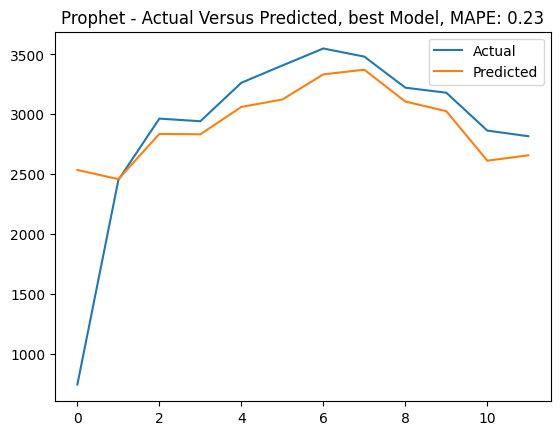

In [134]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.title("Prophet - Actual Versus Predicted, best Model, MAPE: "+ str(round(model_parameters_df['Mape'][0],2)))
pyplot.legend()
pyplot.show()

### Adding Holidays

In [135]:
# First we need to create a dataframe that contains the holidays
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2019-12-25', '2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25']),
  'lower_window': -24,
  'upper_window': 1,
})

# Setting all thanksgivings to the 28th and applying a 27 day lower_window offset so its included in our november dates of 11/01
thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2019-11-28', '2019-11-28', '2021-11-28', '2022-11-28', '2023-11-28']),
  'lower_window': -27,
  'upper_window': 1,
})

julyfourth = pd.DataFrame({
  'holiday': 'julyfourth',
  'ds': pd.to_datetime(['2019-07-04', '2020-07-04', '2021-07-04', '2022-07-04', '2023-07-04']),
  'lower_window': -3,
  'upper_window': 1,
})
holidays = pd.concat([christmas, thanksgiving, julyfourth])

In [136]:
model_holidays = Prophet(changepoint_prior_scale= 0.5,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      yearly_seasonality = True,
                      interval_width=0.8,
                      holidays=holidays)

model_holidays.fit(train)
holiday_forecast = model_holidays.predict(test)

# Calculaint MAPE
y_pred = holiday_forecast['yhat'].values
mape_holiday = mean_absolute_percentage_error(y_true, y_pred)

16:07:05 - cmdstanpy - INFO - Chain [1] start processing
16:08:31 - cmdstanpy - INFO - Chain [1] done processing


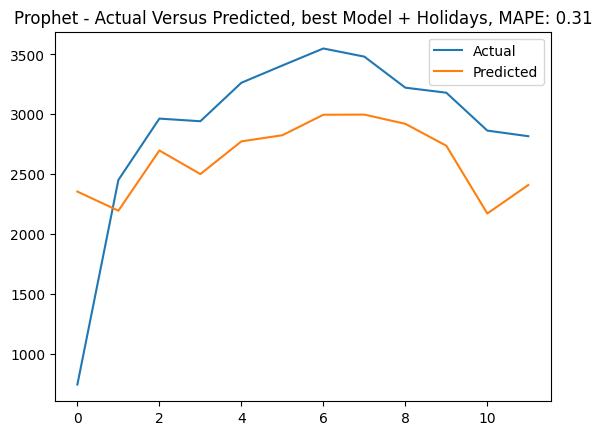

In [137]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.title("Prophet - Actual Versus Predicted, best Model + Holidays, MAPE: "+ str(round(mape_holiday,2)))
pyplot.legend()
pyplot.show()